# This is a notebook for Random Forest  training a model to be able to categorize fake vs real news

In [13]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.svm import SVC
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Make a function to apply text preprocesing to the datasets. </br>
Load the data formating it correctly for easy use and apply the preporcessing </br>
Split the data into a label and title columns so es easy to access only the title for training

In [14]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove Numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra white space
    text = text.strip()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [15]:
# Load the datasets formating them correctly for ease of use
train_data = pd.read_csv(
    r"..\training_data_lowercase.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

test_data = pd.read_csv(
    r"..\testing_data_lowercase_nolabels.csv",
    sep='\t',  # TAB serparator
    header=None,
    names=['label', 'title']
)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...
  label                                              title
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [16]:
# Apply preprocessing to the 'title' column
train_data['title'] = train_data['title'].apply(clean_text)
test_data['title'] = test_data['title'].apply(clean_text)

print(train_data['title'].head())
print(test_data['title'].head())

0    donald trump sends embarrassing new years eve ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas speech
Name: title, dtype: object
0    copycat muslim terrorist arrested assault weapons
1    wow chicago protester caught camera admits vio...
2          germanys fdp look fill schaeubles big shoes
3    mi school sends welcome back packet warning ki...
4    un seeks massive aid boost amid rohingya emerg...
Name: title, dtype: object


Tokenice and stemming to prepare the titles to convert to numbers using TF_IDF

In [17]:
# Tokenize train and testing data
def tokenizeDataframe(text):
    tokens = word_tokenize(text)
    return tokens

train_data['title'] = train_data['title'].apply(tokenizeDataframe)
test_data['title'] = test_data['title'].apply(tokenizeDataframe)

print(train_data.head())
print(test_data.head())

   label                                              title
0      0  [donald, trump, sends, embarrassing, new, year...
1      0  [drunk, bragging, trump, staffer, started, rus...
2      0  [sheriff, david, clarke, becomes, internet, jo...
3      0  [trump, obsessed, even, obamas, name, coded, w...
4      0  [pope, francis, called, donald, trump, christm...
  label                                              title
0     2  [copycat, muslim, terrorist, arrested, assault...
1     2  [wow, chicago, protester, caught, camera, admi...
2     2  [germanys, fdp, look, fill, schaeubles, big, s...
3     2  [mi, school, sends, welcome, back, packet, war...
4     2  [un, seeks, massive, aid, boost, amid, rohingy...


In [18]:
# stemming for simplifying the words
stemmer = PorterStemmer()
train_data['title'] = train_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])
test_data['title'] = test_data['title'].apply(lambda title: [stemmer.stem(word) for word in title])

print("Stemmed Tokens:", train_data['title'].head())
print("Stemmed Tokens:", test_data['title'].head())

Stemmed Tokens: 0    [donald, trump, send, embarrass, new, year, ev...
1    [drunk, brag, trump, staffer, start, russian, ...
2    [sheriff, david, clark, becom, internet, joke,...
3    [trump, obsess, even, obama, name, code, websi...
4    [pope, franci, call, donald, trump, christma, ...
Name: title, dtype: object
Stemmed Tokens: 0    [copycat, muslim, terrorist, arrest, assault, ...
1    [wow, chicago, protest, caught, camera, admit,...
2      [germani, fdp, look, fill, schaeubl, big, shoe]
3    [mi, school, send, welcom, back, packet, warn,...
4    [un, seek, massiv, aid, boost, amid, rohingya,...
Name: title, dtype: object


Apply TF-IDF to the dataset to conver the words into numerical values for model training

In [19]:
# Join tokenized words back into strings
train_data['title'] = train_data['title'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(train_data['title'])

print("\nTF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF Representation:\n", X_tfidf)


TF-IDF Feature Names: ['aar' 'aardvark' 'aaron' ... 'zurich' 'éblacklivesmatt' 'øqu']

TF-IDF Representation:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 297213 stored elements and shape (34152, 15288)>
  Coords	Values
  (0, 3893)	0.26300298396826993
  (0, 13808)	0.11204501106282502
  (0, 11970)	0.3602988733376756
  (0, 4270)	0.37010155056710026
  (0, 9017)	0.23511756235894
  (0, 15175)	0.29851930864715037
  (0, 4496)	0.4591731728534708
  (0, 8437)	0.34775165044814654
  (0, 3818)	0.418711895265266
  (1, 13808)	0.11063881854606479
  (1, 4037)	0.464824398415991
  (1, 1676)	0.39238024516639897
  (1, 12723)	0.3940683663022418
  (1, 12761)	0.3395042582851444
  (1, 11579)	0.28131933141472215
  (1, 2650)	0.4134569577342199
  (1, 6972)	0.31160043778976426
  (2, 12107)	0.3094003802580648
  (2, 3318)	0.33688451396812097
  (2, 2469)	0.3727838315345167
  (2, 1222)	0.2904163960257186
  (2, 6938)	0.2882712362408179
  (2, 7219)	0.3167886136850657
  (2, 13474)	0.25633307087507695
 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, train_data['label'], test_size=0.2, random_state=42)

# Initialize the SVM model
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rfc = rfc_model.predict(X_test)

In [21]:
# Evaluate the model
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
report_rfc = classification_report(y_test, y_pred_rfc)

# Calculate R²
r2 = r2_score(y_test, y_pred_rfc)

print(f"Random Forest Accuracy: {accuracy_rfc}")
print("Random Forest Classification Report:\n", report_rfc)
print(f"R²: {r2}")

Random Forest Accuracy: 0.9206558336993119
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      3529
           1       0.92      0.91      0.92      3302

    accuracy                           0.92      6831
   macro avg       0.92      0.92      0.92      6831
weighted avg       0.92      0.92      0.92      6831

R²: 0.6822724714612627


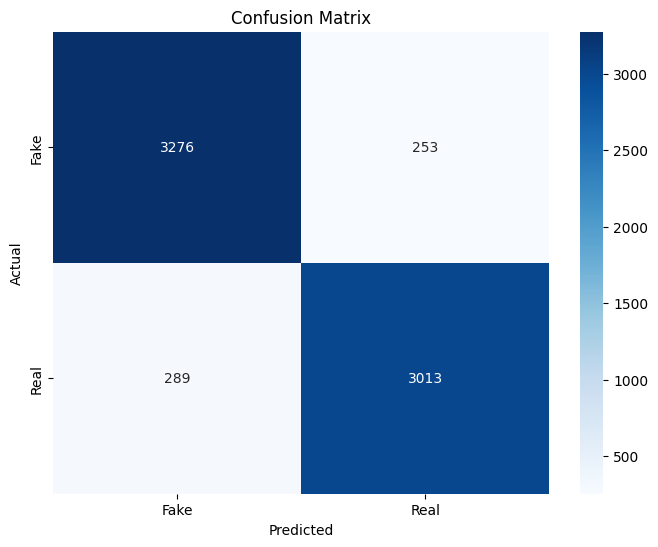

In [22]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rfc)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Predict labels for the testing data and write them on a csv file.

In [23]:
X_test_unlabeled = tfidf_vectorizer.transform(test_data['title'].apply(lambda tokens: ' '.join(tokens)))

# Predict labels for the unlabeled data
predicted_labels = rfc_model.predict(X_test_unlabeled)

test_data['label'] = predicted_labels

# Display the first few rows of the updated testing data
print(test_data.head())

   label                                              title
0      0  [copycat, muslim, terrorist, arrest, assault, ...
1      0  [wow, chicago, protest, caught, camera, admit,...
2      0    [germani, fdp, look, fill, schaeubl, big, shoe]
3      0  [mi, school, send, welcom, back, packet, warn,...
4      1  [un, seek, massiv, aid, boost, amid, rohingya,...


In [24]:
# Make sure title is string, not list
test_data['title'] = test_data['title'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Export respecting original format
test_data[['label', 'title']].to_csv(
    r'stemming_rf_test_data.csv',
    sep='\t',  # TAB separator
    index=False,
    header=False  # No column names
)
print("\n:white_check_mark: Predictions exported successfully in correct format!")


:white_check_mark: Predictions exported successfully in correct format!
